In [3]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit, prange
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar
import glob
import agama

from pyMND.forcetree import construct_tree, force_treeevaluate_loop

from rbf.interpolate import KNearestRBFInterpolant
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167
G = 43018.7

In [4]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=None, 
              fields=['Coordinates', 'Masses', 'Velocities', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

In [5]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [6]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]])
    pos = np.swapaxes(pos, 0, 1)

    pos = np.matmul(Rmat, pos)
    
#     w[:3,:] = np.matmul(Rmat, w[:3,:])
#     w[3:,:] = np.matmul(Rmat, w[3:,:])

    pos = np.swapaxes(pos, 0, 1)
    return pos

# rotate by bar angle at each time step

def rotate_wlist(wlist, bar_angle_out, idx_list):
    bar_angle = np.mod(bar_angle_out['bar_angle'][idx_list], 2.*np.pi)

    Rwlist = np.zeros(np.shape(wlist))

    for i,idx in enumerate(idx_list):
        Rwlist[i] = rotate_w(wlist[i], -bar_angle[i])
    
    return Rwlist

In [5]:
idx = 800
sn = read_snap(idx, 1, lvl='lvl3')
snN = read_snap(idx, 0, lvl='lvl3')

In [6]:
# read in the bar position
phase_space_path = '/n/home01/abeane/starbar/plots/phase_space/data'
in_bar_path = '/n/home01/abeane/starbar/plots/in_bar/data'
nchunk = len(glob.glob(phase_space_path + '/phantom-vacuum-Sg20-Rc3.5-lvl3/phase_space_*'))

pos = np.array([]).reshape((0, 3))
vel = np.array([]).reshape((0, 3))

posN = np.array([]).reshape((0, 3))
velN = np.array([]).reshape((0, 3))

in_bar = np.array([])
in_barN = np.array([])
center = np.array([200., 200., 200.])

for i in tqdm(range(nchunk)):
    ps = h5.File(phase_space_path + '/phantom-vacuum-Sg20-Rc3.5-lvl3/phase_space_phantom-vacuum-Sg20-Rc3.5-lvl3.'+str(i)+'.hdf5',
                 mode='r')
    
    ib = h5.File(in_bar_path + '/in_bar_phantom-vacuum-Sg20-Rc3.5-lvl3/in_bar_phantom-vacuum-Sg20-Rc3.5-lvl3.'+str(i)+'.hdf5',
                 mode='r')

    pos = np.concatenate((pos, ps['PartType2/Coordinates'][idx,:,:]))
    pos = np.concatenate((pos, ps['PartType3/Coordinates'][idx,:,:]))
    pos = np.concatenate((pos, ps['PartType4/Coordinates'][idx,:,:]))
    
    vel = np.concatenate((vel, ps['PartType2/Velocities'][idx,:,:]))
    vel = np.concatenate((vel, ps['PartType3/Velocities'][idx,:,:]))
    vel = np.concatenate((vel, ps['PartType4/Velocities'][idx,:,:]))
    
    in_bar = np.concatenate((in_bar, ib['in_bar'][idx]))
    
    bar_angle = ib['bar_angle'][idx]
    
    ps.close()
    ib.close()

    ps = h5.File(phase_space_path + '/Nbody-lvl3/phase_space_Nbody-lvl3.'+str(i)+'.hdf5', mode='r')
    
    ib = h5.File(in_bar_path + '/in_bar_Nbody-lvl3/in_bar_Nbody-lvl3.'+str(i)+'.hdf5', mode='r')

    posN = np.concatenate((posN, ps['PartType2/Coordinates'][idx,:,:]))
    posN = np.concatenate((posN, ps['PartType3/Coordinates'][idx,:,:]))
    
    velN = np.concatenate((velN, ps['PartType2/Velocities'][idx,:,:]))
    velN = np.concatenate((velN, ps['PartType3/Velocities'][idx,:,:]))
    
    in_barN = np.concatenate((in_barN, ib['in_bar'][idx]))
    
    bar_angleN = ib['bar_angle'][idx]
    
    ps.close()
    ib.close()
    
pos = pos - center
pos = rotate_pos(pos, -bar_angle)
vel = rotate_pos(vel, -bar_angle)

posN = rotate_pos(posN, -bar_angleN)
velN = rotate_pos(velN, -bar_angleN)


    

A Jupyter Widget

In [7]:
# bar_pos = pos[np.where(np.logical_not(in_bar))]
key = np.where(in_bar)[0]
bar_pos = pos[key]
bar_vel = vel[key]

key = np.where(np.logical_not(in_bar))[0]
not_bar_pos = pos[key]
not_bar_vel = vel[key]

bar_mass = np.full(len(bar_pos), sn.MassTable[2].value)

In [8]:
# bar_pos = pos[np.where(np.logical_not(in_bar))]
key = np.where(in_barN)[0]
bar_posN = posN[key]
bar_velN = velN[key]

key = np.where(np.logical_not(in_barN))[0]
not_bar_posN = posN[key]
not_bar_velN = velN[key]

bar_massN = np.full(len(bar_posN), sn.MassTable[2].value)

In [9]:
ang_mom = sn.MassTable[2] * np.cross(bar_pos, bar_vel)
Lz = np.sum(ang_mom[:,2])
print('bar Lz = ', Lz)

bar Lz =  146.9167973456267


In [10]:
ang_mom = sn.MassTable[2] * np.cross(not_bar_pos, not_bar_vel)
Lz = np.nansum(ang_mom[:,2])
print('not bar Lz = ', Lz)

not bar Lz =  6285.764081799653


In [11]:
ang_mom = snN.MassTable[2] * np.cross(bar_posN, bar_velN)
Lz = np.sum(ang_mom[:,2])
print('Nbar Lz = ', Lz)

Nbar Lz =  264.18155669451886


In [12]:
ang_mom = sn.MassTable[2] * np.cross(not_bar_posN, not_bar_velN)
Lz = np.nansum(ang_mom[:,2])
print('not Nbar Lz = ', Lz)

not Nbar Lz =  5218.566266810615


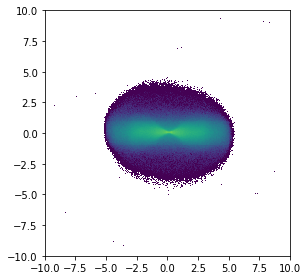

In [36]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = bar_posN[:,0]
y = bar_posN[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


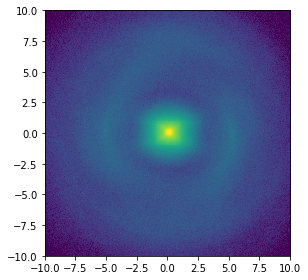

In [35]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = not_bar_posN[:,0]
y = not_bar_posN[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


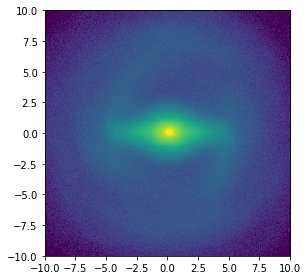

In [37]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = posN[:,0]
y = posN[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=10, vmax=1E4, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()
# fig.colorbar(im, ax=ax)

plt.show()


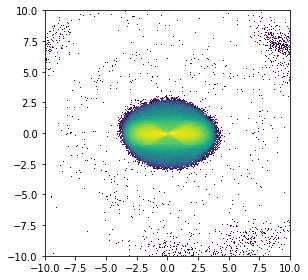

In [15]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = bar_pos[:,0]
y = bar_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


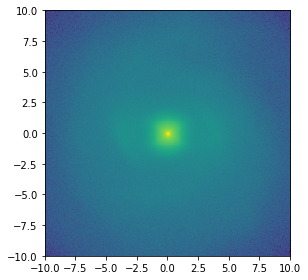

In [16]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = not_bar_pos[:,0]
y = not_bar_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [17]:
gas_pos = sn.part0.pos.value - center
gas_pos = rotate_pos(gas_pos, -bar_angle)
gas_mass = sn.part0.mass.value

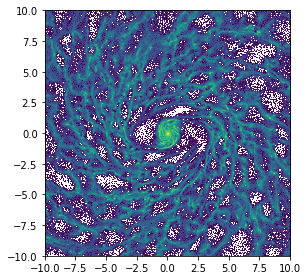

In [18]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = gas_pos[:,0]
y = gas_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [19]:
bar_soft = sn.parameters.SofteningComovingType2
theta = 0.35
maxnode_fac=10.
tree_bar = construct_tree(bar_pos, bar_mass, theta, bar_soft, maxnode_fac=maxnode_fac)

In [20]:
bar_softN = snN.parameters.SofteningComovingType2
theta = 0.35
maxnode_fac=10.
tree_barN = construct_tree(bar_posN, bar_massN, theta, bar_softN, maxnode_fac=maxnode_fac)

In [21]:
acc_gas = G * my_mult(gas_mass, np.array(force_treeevaluate_loop(gas_pos, tree_bar)))
torque_tree = np.cross(gas_pos, acc_gas)
tz_tree = torque_tree[:,2]

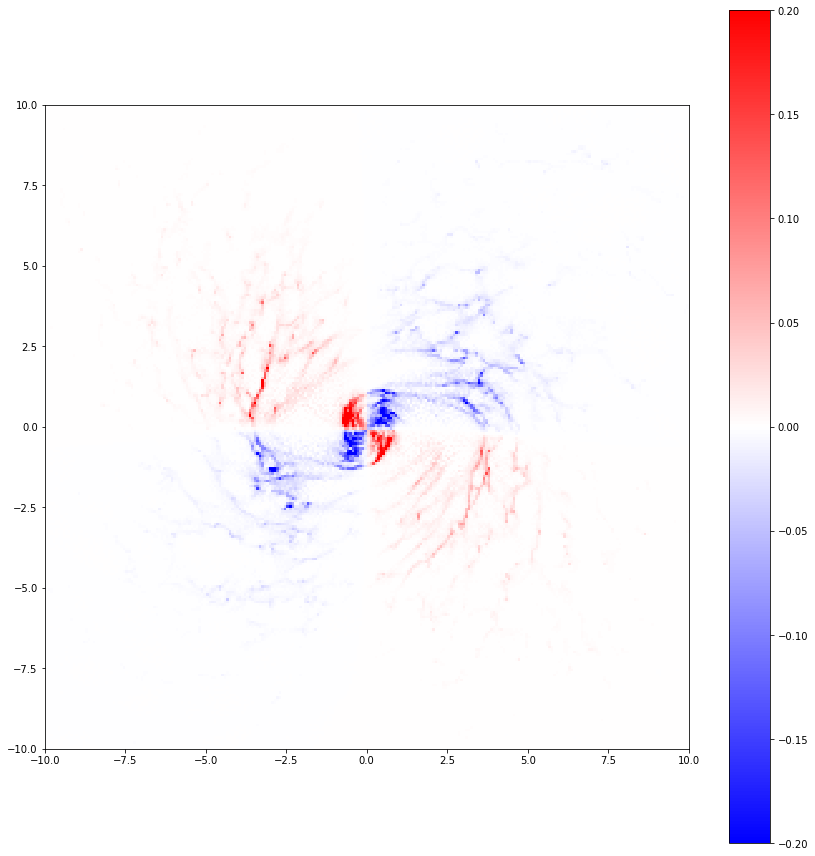

In [22]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = gas_pos[:,0]
y = gas_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=tz_tree)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', cmap='bwr', vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('equal')
fig.colorbar(im)

fig.tight_layout()

plt.show()


In [23]:
Rgas = np.linalg.norm(gas_pos[:,:2], axis=1)
key_Rless = Rgas < 2
key_Rmore = np.logical_not(key_Rless)

tz_Rless = np.sum(tz_tree[key_Rless])
tz_Rmore = np.sum(tz_tree[key_Rmore])

print('tz Rless=', tz_Rless)
print('tz Rmore=', tz_Rmore)


tz Rless= -5.831110166856611
tz Rmore= -6.853205154695655


In [24]:
delta = (1/360) * 2. * np.pi
print(delta)
art_angle = np.array([-delta, -delta/2.0, 0, delta/2.0, delta])
tot_tz = []
for ang in tqdm(art_angle):
    gas_pos_art_angle = rotate_pos(gas_pos, ang)
    
    acc_gas_tree = 43007.1 * my_mult(gas_mass, np.array(force_treeevaluate_loop(gas_pos_art_angle, tree_bar)))
    torque_tree = np.cross(gas_pos, acc_gas_tree)
    tz_tree = torque_tree[:,2]
    
    Rgas = np.linalg.norm(gas_pos_art_angle[:,:2], axis=1)
    key_Rless = Rgas < 2
    key_Rmore = np.logical_not(key_Rless)

    tz_Rless = np.sum(tz_tree[key_Rless])
    tz_Rmore = np.sum(tz_tree[key_Rmore])

    print('delta = ', delta)
    print('tz Rless=', tz_Rless)
    print('tz Rmore=', tz_Rmore)
    
    tot_tz.append(np.sum(tz_tree))
    
print(tot_tz)

0.017453292519943295


A Jupyter Widget

delta =  0.017453292519943295
tz Rless= -4.639380947910892
tz Rmore= 29.56924677136659
delta =  0.017453292519943295
tz Rless= -5.234737745918024
tz Rmore= 11.365441426386598
delta =  0.017453292519943295
tz Rless= -5.829537806977406
tz Rmore= -6.851357186723718
delta =  0.017453292519943295
tz Rless= -6.426733807367088
tz Rmore= -25.027468919074224
delta =  0.017453292519943295
tz Rless= -7.025644496002709
tz Rmore= -43.230821227990255

[24.929865823455685, 6.130703680468575, -12.680894993701122, -31.45420272644131, -50.256465723992946]


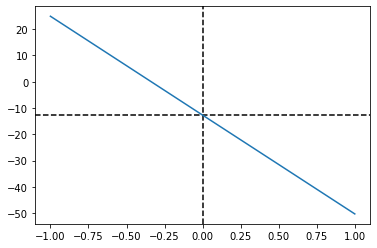

[24.929865823455685,
 6.130703680468575,
 -12.680894993701122,
 -31.45420272644131,
 -50.256465723992946]

In [25]:
plt.axvline(0, c='k', ls='dashed')
plt.axhline(tot_tz[2], c='k', ls='dashed')
plt.plot(art_angle * (360/2./np.pi), tot_tz)

plt.show()
tot_tz

In [26]:
halo_pos = sn.part1.pos.value - center
halo_pos = rotate_pos(halo_pos, -bar_angle)

halo_posN = snN.part1.pos.value
halo_posN = rotate_pos(halo_posN, -bar_angleN)


In [27]:
halo_acc = G * sn.MassTable[1] * np.array(force_treeevaluate_loop(halo_pos, tree_bar, num_threads=24))
torque_halo = np.cross(halo_pos, halo_acc)
tz_halo_sum = np.sum(torque_halo[:,:2])

In [28]:
not_bar_acc = G * sn.MassTable[2] * np.array(force_treeevaluate_loop(not_bar_pos, tree_bar, num_threads=24))
torque_not_bar = np.cross(not_bar_pos, not_bar_acc)
tz_not_bar_sum = np.nansum(torque_not_bar[:,:2])

In [29]:
halo_accN = G * snN.MassTable[1] * np.array(force_treeevaluate_loop(halo_posN, tree_barN, num_threads=24))
torque_haloN = np.cross(halo_posN, halo_accN)
tz_haloN_sum = np.sum(torque_haloN[:,:2])

In [30]:
not_bar_accN = G * snN.MassTable[2] * np.array(force_treeevaluate_loop(not_bar_posN, tree_barN, num_threads=24))
torque_not_barN = np.cross(not_bar_posN, not_bar_accN)
tz_not_barN_sum = np.nansum(torque_not_barN[:,:2])

KeyboardInterrupt: 

In [ ]:
print('tz halo: ', tz_halo_sum)
print('tz not bar: ', tz_not_bar_sum)
print('tz halo: ', tz_haloN_sum)
print('tz not bar: ', tz_not_barN_sum)

## Torques over time

In [1]:
def read_bar_prop(name):
    prefix = '/n/home01/abeane/starbar/plots/'
    prefix_bar_prop = prefix + 'bar_prop/data/'
    
    fin = prefix_bar_prop + 'bar_prop_' + name + '.hdf5'
    h5in = h5.File(fin, mode='r')
    
    out = {}
    for key in h5in.keys():
        if key=='bar_prop':
            out[key] = {}
            for k2 in h5in[key].keys():
                out[key][k2] = np.array(h5in[key][k2])
        else:
            out[key] = np.array(h5in[key])
    
    h5in.close()
    
    return out

In [7]:
idx_list = np.arange(0, 1200)

torque_path = '/n/home01/abeane/starbar/plots/torques/data'
gas_base = torque_path + '/torques_phantom-vacuum-Sg20-Rc3.5-lvl3/torques_phantom-vacuum-Sg20-Rc3.5-lvl3.'
rstHalo_base = torque_path + '/torques_phantom-vacuum-Sg20-Rc3.5-lvl3-rstHalo/torques_phantom-vacuum-Sg20-Rc3.5-lvl3-rstHalo.'
N_base = torque_path + '/torques_Nbody-lvl3/torques_Nbody-lvl3.'

tz_halo = []
tz_not_bar = []
tz_gas = []
time = []

tz_halo_rH = []
tz_not_bar_rH = []
tz_gas_rH = []
time_rH = []

tz_haloN = []
tz_not_barN = []

for idx in tqdm(idx_list):
#     sn = read_snap(idx, 1, parttype=[0], fields=['Masses'])
    
    fname = gas_base + str(idx) + '.hdf5'
    
    t = h5.File(fname, mode='r')
    
#     torque_halo = sn.MassTable[1].value * np.cross(np.array(t['pos_halo']), np.array(t['acc_halo']))
    torque_halo = t['total_torques'].attrs['halo']
    tz_halo.append(torque_halo[2])
    
#     torque_not_bar = sn.MassTable[2].value * np.cross(np.array(t['pos_notbar']), np.array(t['acc_notbar']))
    torque_not_bar = t['total_torques'].attrs['not_bar']
    tz_not_bar.append(torque_not_bar[2])
    
#     torque_gas = my_mult(sn.part0.mass.value, np.cross(np.array(t['pos_gas']), np.array(t['acc_gas'])))
    torque_gas = t['total_torques'].attrs['gas']
    tz_gas.append(torque_gas[2])
    
    time.append(t['parameters'].attrs['Time'])
    
    t.close()


    
    
    fname = N_base + str(idx) + '.hdf5'
    t = h5.File(fname, mode='r')
    
    torque_halo = t['total_torques'].attrs['halo']
    tz_haloN.append(torque_halo[2])
    
    torque_not_bar = t['total_torques'].attrs['not_bar']
    tz_not_barN.append(torque_not_bar[2])
    
    
#     time.append(t['parameters'].attrs['Time'])
    
    t.close()
    
    try:
#     if True:
        fname = rstHalo_base + str(idx) + '.hdf5'
        t = h5.File(fname, mode='r')
        
        time_rH.append(t['parameters'].attrs['Time'])
    
        torque_halo = t['total_torques'].attrs['halo']
        tz_halo_rH.append(torque_halo[2])
    
        torque_not_bar = t['total_torques'].attrs['not_bar']
        tz_not_bar_rH.append(torque_not_bar[2])
        
        torque_gas = t['total_torques'].attrs['gas']
        tz_gas_rH.append(torque_gas[2])
    
    
        t.close()
    except:
#         print(idx)
        pass
    

tz_halo = np.array(tz_halo)
tz_not_bar = np.array(tz_not_bar)
tz_gas = np.array(tz_gas)

tz_halo_rH = np.array(tz_halo_rH)
tz_not_bar_rH = np.array(tz_not_bar_rH)
tz_gas_rH = np.array(tz_gas_rH)

tz_haloN = np.array(tz_haloN)
tz_not_barN = np.array(tz_not_barN)

time = np.array(time)

A Jupyter Widget

In [8]:
bar_prop_Nbody4 = read_bar_prop('Nbody-lvl4')
bar_prop_Nbody3 = read_bar_prop('Nbody-lvl3')
bar_prop_gas4 = read_bar_prop('phantom-vacuum-Sg20-Rc3.5-lvl4')
bar_prop_gas3 = read_bar_prop('phantom-vacuum-Sg20-Rc3.5-lvl3')
bar_prop_gas3rH = read_bar_prop('phantom-vacuum-Sg20-Rc3.5-lvl3-rstHalo')

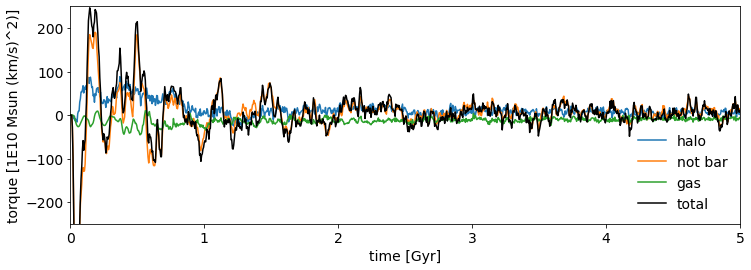

In [16]:
font = {'size'   : 14}

mpl.rc('font', **font)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(time, tz_halo, label='halo')
ax.plot(time, tz_not_bar, label='not bar')
ax.plot(time, tz_gas, label='gas')
# plt.plot(time, tz_halo + tz_gas, label='gas + halo')
ax.plot(time, tz_gas + tz_halo + tz_not_bar, c='k', label='total')

bar_prop = bar_prop_gas3['bar_prop']

dIzdt = np.gradient(bar_prop['Izbar'], bar_prop['tlist'])
# ax[1].plot(bar_prop['tlist'], dIzdt)

ax.set_xlim(0, 5.0)
ax.set(ylim=(-250, 250), xlabel='time [Gyr]', ylabel='torque [1E10 Msun (km/s)^2)]')

# ax.set(ylim=(-10, 10))

ax.legend(frameon=False)
plt.show()

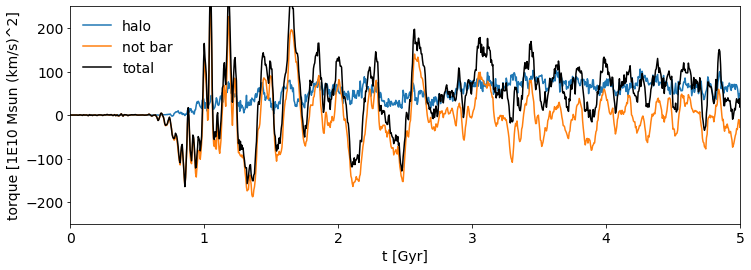

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(time, tz_haloN, label='halo')
ax.plot(time, tz_not_barN, label='not bar')
# plt.plot(time, tz_gas, label='gas')
# plt.plot(time, tz_halo + tz_gas, label='gas + halo')
ax.plot(time, tz_haloN + tz_not_barN, c='k', label='total')
# ax.axvline(time[625])
# ax.axvline(time[575])
# ax.axvline(time[500])

bar_prop = bar_prop_Nbody3['bar_prop']

# ax[1].plot(bar_prop['tlist'], bar_prop['Lzbar'])
# y = tz_haloN + tz_not_barN
# ax[1].plot(time, y/10 + 200, c='k', label='total')

# bar_prop['Izbar']
# t = bar_prop

# plt.ylim(-30, 30)
ax.set_xlim(0, 5.0)
ax.set(ylim=(-250, 250), xlabel='t [Gyr]', ylabel='torque [1E10 Msun (km/s)^2]')

ax.legend(frameon=False)
plt.show()

In [11]:
bar_prop['tlist'].shape

(1601,)

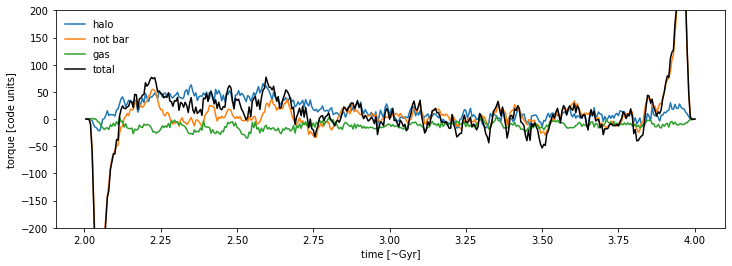

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(time_rH, tz_halo_rH, label='halo')
ax.plot(time_rH, tz_not_bar_rH, label='not bar')
ax.plot(time_rH, tz_gas_rH, label='gas')
# plt.plot(time, tz_halo + tz_gas, label='gas + halo')
ax.plot(time_rH, tz_gas_rH + tz_halo_rH + tz_not_bar_rH, c='k', label='total')

# plt.ylim(-30, 30)
# ax.set_xlim(2, None)
ax.set(ylim=(-200, 200))

ax.set(xlabel='time [~Gyr]', ylabel='torque [code units]')

ax.legend(frameon=False)
plt.show()

In [30]:
print('average gas torque in first Gyr: ', np.mean(tz_gas[:200]))
print('average gas torque in last Gyr: ', np.mean(tz_gas[200:]))

average gas torque in first Gyr:  -17.38773651542194
average gas torque in last Gyr:  -11.00236198156433


In [54]:
bar_prop = bar_prop_gas3rH['bar_prop']
Omega_p = 40.0

dLz = bar_prop['Lzbar'][200] - bar_prop['Lzbar'][50]
dIz = bar_prop['Izbar'][200] - bar_prop['Izbar'][50]
dt = bar_prop['tlist'][200] - bar_prop['tlist'][50]

deltaLz_deltat = dLz/dt
deltaIz_deltat = dIz/dt

dOmega_p = dt * (deltaLz_deltat - Omega_p * deltaIz_deltat) / Iz

Iz = bar_prop['Izbar'][200]
print('dLzdt = ', deltaLz_deltat)
print('Omega_p * deltaIz_deltat = ', Omega_p * deltaIz_deltat)
print('expected dOmega_p/dt = ', dOmega_p/dt)
print('expected delta Omega = ', dOmega_p)
print('Lz/Iz - Lz/Iz = ', (bar_prop['Lzbar'][200]/bar_prop['Izbar'][200])- \
      (bar_prop['Lzbar'][50]/bar_prop['Izbar'][50]))

dLzdt =  -9.648271236122165
Omega_p * deltaIz_deltat =  0.27690727390930664
expected dOmega_p/dt =  -4.192492775403618
expected delta Omega =  -3.1443695815527137
Lz/Iz - Lz/Iz =  -3.2197135657970932


In [52]:
print(Iz)

2.3673692577981744


In [11]:
print('not bar:', np.mean(tz_not_barN[400:1000]))
print('halo:', np.mean(tz_haloN[400:1000]))

tot_torqueN = tz_not_barN + tz_haloN
print('Nbody mean torque: ', np.mean(tot_torqueN[400:1000]))

not bar: -8.13500074840756
halo: 62.46064874734773
Nbody mean torque:  54.32564799894017


In [12]:
print('not bar:', np.mean(tz_not_bar[400:1000]))
print('halo:', np.mean(tz_halo[400:1000]))
print('gas:', np.mean(tz_gas[400:1000]))

tot_torque = tz_not_bar + tz_halo + tz_gas
print('SMUGGLE mean torque:', np.mean(tot_torque[400:1000]))

not bar: 6.707588359400468
halo: 8.732328528439186
gas: -10.89506255991007
SMUGGLE mean torque: 4.5448543279295865


In [13]:
print('not bar:', np.mean(tz_not_bar[0:200]))
print('halo:', np.mean(tz_halo[0:200]))
print('gas:', np.mean(tz_gas[0:200]))

print('SMUGGLE mean torque: ', np.mean(tot_torque[0:200]))

not bar: -13.767101561346532
halo: 38.68511751617802
gas: -17.38773651542194
SMUGGLE mean torque:  7.530279439409546


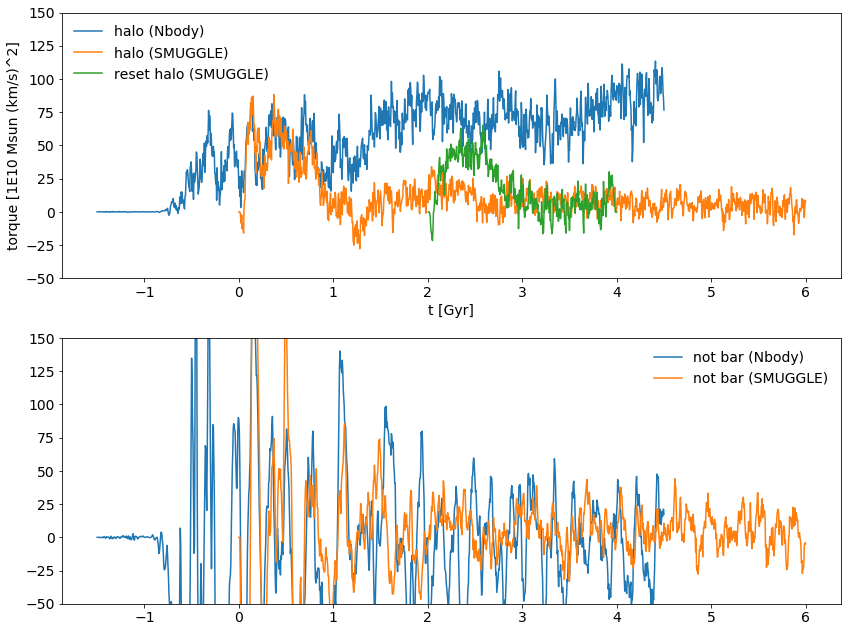

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9))

ax[0].plot(time - time[300], tz_haloN, label = 'halo (Nbody)')
ax[0].plot(time, tz_halo, label = 'halo (SMUGGLE)')
ax[0].plot(time_rH, tz_halo_rH, label = 'reset halo (SMUGGLE)')


ax[1].plot(time - time[300], tz_not_barN, label = 'not bar (Nbody)')
ax[1].plot(time, tz_not_bar, label = 'not bar (SMUGGLE)')

# ax[0].set_xlim(1.5, 5.0)
ax[0].set(ylim=(-50, 150), xlabel='t [Gyr]', ylabel='torque [1E10 Msun (km/s)^2]')
ax[1].set(ylim=(-50, 150))

ax[0].legend(frameon=False)
ax[1].legend(frameon=False)

fig.tight_layout()

plt.show()

In [38]:
key = np.where(time>2.5)[0][0]
dLz_gas = np.trapz(tz_gas[key:], time[key:])
print('dLz_gas:', dLz_gas)

dLz_halo = np.trapz(tz_halo[key:], time[key:])
dLz_not_bar = np.trapz(tz_not_bar[key:], time[key:])
print('dLz_halo:', dLz_halo)
print('dLz_not_bar:', dLz_not_bar)
print('dLz tot:', dLz_gas + dLz_halo + dLz_not_bar)

dLz_gas: -33.946966796958314
dLz_halo: 21.608616521000947
dLz_not_bar: 17.227589629867882
dLz tot: 4.889239353910515


In [39]:
key = np.where(time>2.5)[0][0]
# dLz_gas = np.trapz(tz_gasN[key:], time[key:])
# print('dLz_gas:', dLz_gas)

dLz_halo = np.trapz(tz_haloN[key:], time[key:])
dLz_not_bar = np.trapz(tz_not_barN[key:], time[key:])
print('dLz_halo Nbody:', dLz_halo)
print('dLz_not_bar Nbody:', dLz_not_bar)
print('dLz tot Nbody:', dLz_gas + dLz_halo + dLz_not_bar)

dLz_halo Nbody: 246.55817132477986
dLz_not_bar Nbody: -2.3798765506564674
dLz tot Nbody: 210.23132797716508


In [40]:
key = np.where(time<1.0)[0]
dLz_gas = np.trapz(tz_gas[key], time[key])
print('dLz_gas:', dLz_gas)

dLz_halo = np.trapz(tz_halo[key], time[key])
dLz_not_bar = np.trapz(tz_not_bar[key], time[key])
print('dLz_halo:', dLz_halo)
print('dLz_not_bar:', dLz_not_bar)
print('dLz tot:', dLz_gas + dLz_halo + dLz_not_bar)

dLz_gas: -17.307212857350343
dLz_halo: 38.68065319280637
dLz_not_bar: -13.647049747168559
dLz tot: 7.726390588287465


In [41]:
time_binned, tz_halo_binned = binned_average(time, tz_halo, 0.1)
time_binned, tz_not_bar_binned = binned_average(time, tz_not_bar, 0.1)
time_binned, tz_gas_binned = binned_average(time, tz_gas, 0.1)

plt.plot(time_binned, tz_halo_binned, label='halo')
plt.plot(time_binned, tz_not_bar_binned, label='not bar')
plt.plot(time_binned, tz_gas_binned, label='gas')
# plt.plot(time, tz_halo + tz_gas, label='gas + halo')
plt.plot(time_binned, tz_gas_binned + tz_halo_binned + tz_not_bar_binned, c='k', label='total')

# plt.ylim(-30, 30)
plt.xlim(2, None)

plt.legend(frameon=False)
plt.show()

NameError: name 'binned_average' is not defined

In [ ]:
key = np.where(time > 2.)
tz_not_gas = tz_halo + tz_not_bar

print(np.sum(tz_not_gas[key]))
print(np.sum(tz_gas[key]))

In [ ]:
plt.plot(idx_list, tz_haloN)
plt.plot(idx_list, tz_not_barN)
# plt.plot(idx_list, tz_gas)
plt.show()

In [ ]:
torque_path = '/n/home01/abeane/starbar/plots/torques/data'
gas_base = torque_path + '/torques_phantom-vacuum-Sg20-Rc3.5-lvl3/torques_phantom-vacuum-Sg20-Rc3.5-lvl3.'
N_base = torque_path + '/torques_Nbody-lvl3/torques_Nbody-lvl3.'


t = h5.File(gas_base + '7.hdf5', mode='r')


In [ ]:
t['total_torques'].attrs.keys()

In [ ]:
t = h5.File('tmp.h5', mode='w')

In [ ]:
g = t.create_group('test')

In [ ]:
g.attrs.create('array', np.random.rand(10))

In [ ]:
t.close()

In [30]:
phase_space_path = '/n/home01/abeane/starbar/plots/phase_space/data'
in_bar_path = '/n/home01/abeane/starbar/plots/in_bar/data'
nchunk = len(glob.glob(phase_space_path + '/phantom-vacuum-Sg20-Rc3.5-lvl3/phase_space_*'))

In [31]:
i = 0
ps = h5.File(phase_space_path + '/phantom-vacuum-Sg20-Rc3.5-lvl3/phase_space_phantom-vacuum-Sg20-Rc3.5-lvl3.'+str(i)+'.hdf5',
                 mode='r')

In [39]:
ps['PartType2']['Coordinates'][4]

array([[198.20025493, 200.35126598, 199.39856404],
       [189.05159105, 192.34261747, 199.86747762],
       [200.076956  , 200.10201367, 199.62406277],
       ...,
       [204.67868407, 199.96790894, 200.29360363],
       [206.86324057, 194.65879713, 199.96430441],
       [199.62529506, 198.9221937 , 200.56794738]])